In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,Dropout
import os
import warnings
from tensorflow import keras
warnings.filterwarnings('ignore')
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from numpy import mean, std, sqrt, percentile
from scipy.stats import skew, kurtosis

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving grenade_raw.csv to grenade_raw (1).csv
Saving hammer_raw.csv to hammer_raw (1).csv
Saving logout_raw.csv to logout_raw (1).csv
Saving portal_raw.csv to portal_raw (1).csv
Saving punch_raw.csv to punch_raw (1).csv
Saving reload_raw.csv to reload_raw (1).csv
Saving shield_raw.csv to shield_raw (1).csv
Saving spear_raw.csv to spear_raw (1).csv
Saving web_raw.csv to web_raw (1).csv


In [ ]:
from google.colab import files
!ls

 best_model_fold_1.h5   grenade_raw.csv       portal_raw.csv	   'shield_raw (1).csv'
 best_model_fold_2.h5  'hammer_raw (1).csv'  'punch_raw (1).csv'    shield_raw.csv
 best_model_fold_3.h5   hammer_raw.csv	      punch_raw.csv	   'spear_raw (1).csv'
 best_model_fold_4.h5  'logout_raw (1).csv'  'reload_raw (1).csv'   spear_raw.csv
 best_model_fold_5.h5   logout_raw.csv	      reload_raw.csv	   'web_raw (1).csv'
'grenade_raw (1).csv'  'portal_raw (1).csv'   sample_data	    web_raw.csv


## Print the Shape of 20Hz Sample Rate Raw Data

In [ ]:
fist_raw = pd.read_csv('punch_raw.csv')
grenade_raw = pd.read_csv('grenade_raw.csv')
hammer_raw = pd.read_csv('hammer_raw.csv')
logout_raw = pd.read_csv('logout_raw.csv')
portal_raw = pd.read_csv('portal_raw.csv')
reload_raw = pd.read_csv('reload_raw.csv')
shield_raw = pd.read_csv('shield_raw.csv')
spear_raw = pd.read_csv('spear_raw.csv')
spiderweb_raw = pd.read_csv('web_raw.csv')

print(f'Shape of fist raw is: {fist_raw.shape}')
print(f'Shape of grenade raw is: {grenade_raw.shape}')
print(f'Shape of hammer raw is: {hammer_raw.shape}')
print(f'Shape of logout raw is: {logout_raw.shape}')
print(f'Shape of portal raw is: {portal_raw.shape}')
print(f'Shape of reload raw is: {reload_raw.shape}')
print(f'Shape of shield raw is: {shield_raw.shape}')
print(f'Shape of spear raw is: {spear_raw.shape}')
print(f'Shape of spiderweb raw is: {spiderweb_raw.shape}')

Shape of fist raw is: (33750, 6)
Shape of grenade raw is: (33150, 6)
Shape of hammer raw is: (32200, 6)
Shape of logout raw is: (31650, 6)
Shape of portal raw is: (32150, 6)
Shape of reload raw is: (31500, 6)
Shape of shield raw is: (32550, 6)
Shape of spear raw is: (31200, 6)
Shape of spiderweb raw is: (31350, 6)


In [ ]:
all_raw = np.concatenate((
    fist_raw,
    grenade_raw,
    hammer_raw,
    logout_raw,
    portal_raw,
    reload_raw,
    shield_raw,
    spear_raw,
    spiderweb_raw,
), axis=0)

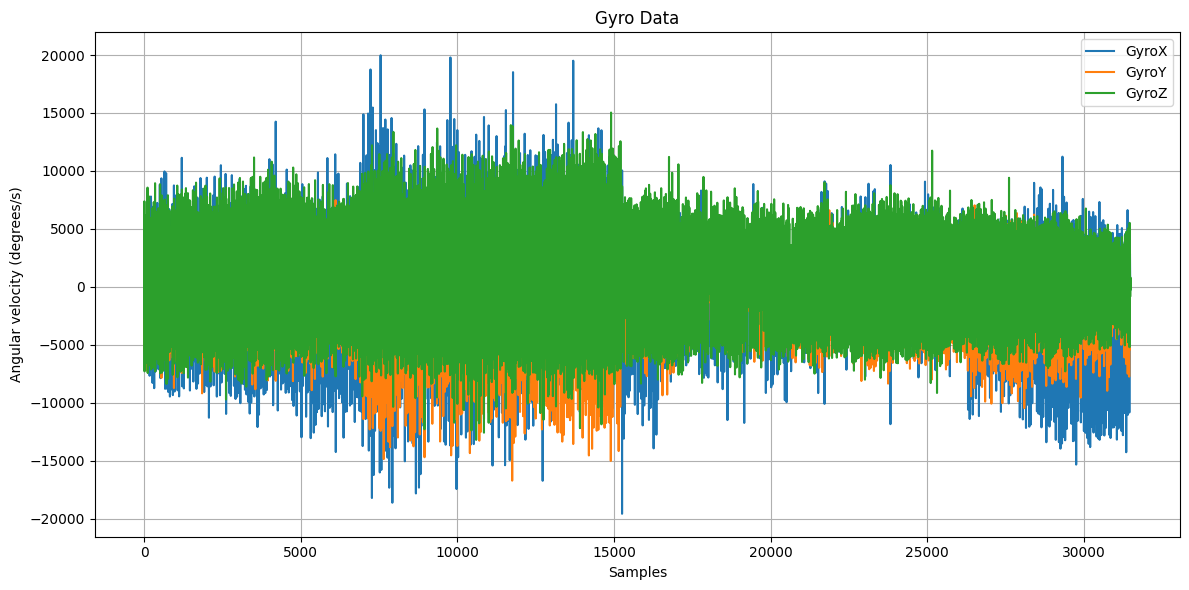

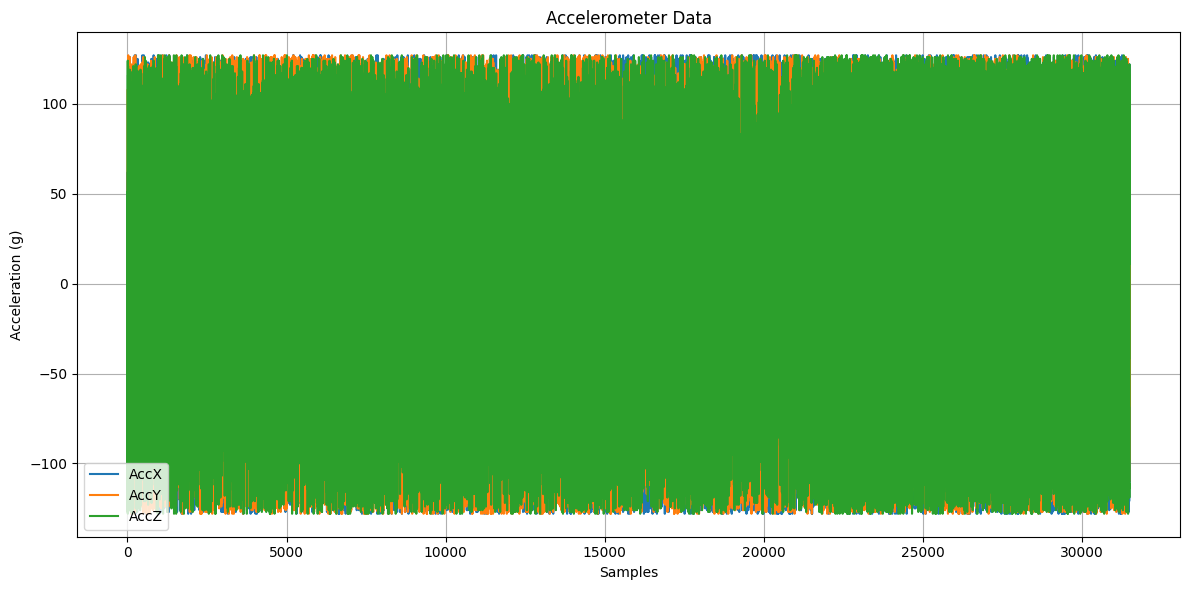

In [ ]:
import matplotlib.pyplot as plt

df_subset = reload_raw.iloc[:, :]

# Plotting gyro data
df_subset[['GyroX', 'GyroY', 'GyroZ']].plot(figsize=(12, 6), title='Gyro Data')
plt.ylabel("Angular velocity (degrees/s)")
plt.xlabel("Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting accel data
df_subset[['AccX', 'AccY', 'AccZ']].plot(figsize=(12, 6), title='Accelerometer Data')
plt.ylabel("Acceleration (g)")
plt.xlabel("Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


## Normalization

In [ ]:
# mean std normalisation
def get_mean_std(X):
    mean = []
    std = []
    for i in range(X.shape[1]):
        col_mean = np.mean(X[:, i])
        col_std = np.std(X[:, i])
        mean.append(col_mean)
        std.append(col_std)
    return mean, std

mean, std = get_mean_std(all_raw)
print(mean)
print(std)

[-2.0964732297063904, 0.04991018998272884, 0.6419723661485319, -84.94949568221071, -4.250818652849741, 51.14255958549223]
[74.90506388888184, 74.54468775642907, 74.83793561578511, 2588.828507875095, 2702.4807916649443, 3360.1296371988565]


In [ ]:
def normalize(X, mean, std):
    X_norm = np.zeros_like(X, dtype=float)
    for i in range(X.shape[1]):
        X_norm[:, i] = (X[:, i] - mean[i]) / std[i]
    return X_norm

fist_raw_norm = normalize(fist_raw.to_numpy(), mean, std)
grenade_raw_norm = normalize(grenade_raw.to_numpy(), mean, std)
hammer_raw_norm = normalize(hammer_raw.to_numpy(), mean, std)
logout_raw_norm = normalize(logout_raw.to_numpy(), mean, std)
portal_raw_norm = normalize(portal_raw.to_numpy(), mean, std)
reload_raw_norm = normalize(reload_raw.to_numpy(), mean, std)
shield_raw_norm = normalize(shield_raw.to_numpy(), mean, std)
spear_raw_norm = normalize(spear_raw.to_numpy(), mean, std)
spiderweb_raw_norm = normalize(spiderweb_raw.to_numpy(), mean, std)

## Create Window

In [ ]:
# Function to create windows for input
def create_window(raw, window_size=50, overlap=50):
    num_windows = (len(raw) - window_size) // overlap + 1
    window = np.zeros((num_windows, window_size, raw.shape[1]))

    for i in range(num_windows):
        start = i * overlap
        end = start + window_size
        window[i] = raw[start:end, :]

    return window


In [ ]:
# Create inputs and labels for each class
fist_input = create_window(fist_raw_norm)
grenade_input = create_window(grenade_raw_norm)
hammer_input = create_window(hammer_raw_norm)
logout_input = create_window(logout_raw_norm)
portal_input = create_window(portal_raw_norm)
reload_input = create_window(reload_raw_norm)
shield_input = create_window(shield_raw_norm)
spear_input = create_window(spear_raw_norm)
spiderweb_input = create_window(spiderweb_raw_norm)

## Feature Extraction for each window

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def extract_features(window, label):
    features = []

    for col in window.columns:
        # Time domain features
        tmean = np.mean(window[col])
        tstd = np.std(window[col])
        t25percentile = np.percentile(window[col], 25)
        t50percentile = np.percentile(window[col], 50)  # median
        t75percentile = np.percentile(window[col], 75)
        tIQR = t75percentile - t25percentile  # interquartile range
        zero_crossings = np.where(np.diff(np.sign(window[col])))[0].size  # zero-crossings
        tMAD = np.mean(np.abs(window[col] - tmean))

        features.extend([
            # tmean,
            # tstd,
            t50percentile,
            tIQR,
            zero_crossings,
            tMAD,
            skew(window[col]),
            kurtosis(window[col])
        ])

        # Frequency domain features
        freq_domain = np.fft.rfft(window[col])
        freq_magnitude = np.abs(freq_domain)
        freq_axis = np.fft.rfftfreq(len(window[col]))

        fmean = np.mean(freq_magnitude)
        fmax = np.max(freq_magnitude)
        dominant_freq = freq_axis[np.argmax(freq_magnitude)]
        energy = np.sum(np.square(freq_magnitude)) / 10000  # divided by 100^2
        fsum = np.sum(freq_magnitude)
        entropy = -np.sum((freq_magnitude / fsum) * np.log2(freq_magnitude / fsum + np.finfo(float).eps))  # spectral entropy


        features.extend([
            fmean,
            fmax,
            dominant_freq,
            energy,
            entropy
        ])

    features.append(label)
    return features


In [ ]:
feature = []

for i in range(fist_input.shape[0]):
    window = pd.DataFrame(fist_input[i])
    features = extract_features(window, "fist")
    feature.append(features)
for i in range(grenade_input.shape[0]):
    window = pd.DataFrame(grenade_input[i])
    features = extract_features(window, "grenade")
    feature.append(features)
for i in range(hammer_input.shape[0]):
    window = pd.DataFrame(hammer_input[i])
    features = extract_features(window, "hammer")
    feature.append(features)
for i in range(logout_input.shape[0]):
    window = pd.DataFrame(logout_input[i])
    features = extract_features(window, "logout")
    feature.append(features)
for i in range(portal_input.shape[0]):
    window = pd.DataFrame(portal_input[i])
    features = extract_features(window, "portal")
    feature.append(features)
for i in range(reload_input.shape[0]):
    window = pd.DataFrame(reload_input[i])
    features = extract_features(window, "reload")
    feature.append(features)
for i in range(shield_input.shape[0]):
    window = pd.DataFrame(shield_input[i])
    features = extract_features(window, "shield")
    feature.append(features)
for i in range(spear_input.shape[0]):
    window = pd.DataFrame(spear_input[i])
    features = extract_features(window, "spear")
    feature.append(features)
for i in range(spiderweb_input.shape[0]):
    window = pd.DataFrame(spiderweb_input[i])
    features = extract_features(window, "spiderweb")
    feature.append(features)
# for i in range(idle_norm.shape[0]):
#     window = pd.DataFrame(idle_norm[i])
#     features = extract_features(window, "idle")
#     feature.append(features)
columns = [
    f'{col}_{stat}' for col in window.columns
    for stat in [
        # 'tmean', 'tstd',
        't50percentile',
        'tIQR', 'zero_crossings', 'tMAD', 'tskew', 'tkurtosis',
        'fmean', 'fmax', 'dominant_freq',
        'fenergy', 'fentropy'
    ]
]
columns.append('label')
feature_df = pd.DataFrame(feature, columns=columns)  # make sure `features` is the list of extracted features.


print(feature_df)

      0_t50percentile    0_tIQR  0_zero_crossings    0_tMAD   0_tskew  \
0           -0.612823  0.604098                 8  0.556181  1.092863   
1           -0.586122  1.248247                10  0.790569  0.634830   
2           -0.319118  1.488551                13  0.766325  0.659544   
3           -0.519371  0.647486                 8  0.541272  0.718597   
4           -0.552747  0.817702                12  0.584099  0.813597   
...               ...       ...               ...       ...       ...   
5785        -0.412569  2.439755                14  1.126375  0.196704   
5786        -0.225666  2.429742                25  1.074160  0.179355   
5787         0.408470  2.489818                16  1.080044 -0.127640   
5788         0.134790  2.352978                12  1.151591 -0.027460   
5789         0.528622  1.525264                13  0.825578 -0.363558   

      0_tkurtosis   0_fmean     0_fmax  0_dominant_freq  0_fenergy  ...  \
0        1.330478  5.330352  23.071555          

<Axes: >

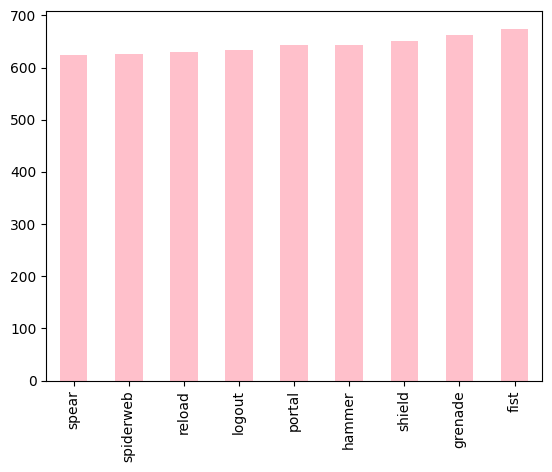

In [ ]:
shuffled_df = feature_df.sample(frac = 1)
shuffled_df['label'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

In [ ]:
from sklearn.model_selection import train_test_split

x_data, y_data = shuffled_df.iloc[:, :-1], shuffled_df.iloc[:, -1:]
x_data = x_data.astype("float32")
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, random_state=0, train_size = .80) # put 20% of data into test

print("train_x size:", train_x.shape, "train_y size:", train_y.shape)
print("test_x size:", test_x.shape, "test_y size:", test_y.shape)

train_x size: (4632, 66) train_y size: (4632, 1)
test_x size: (1158, 66) test_y size: (1158, 1)


In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)
le_name_mapping = dict(zip(le.classes_, le.fit_transform(le.classes_)))
print(le_name_mapping)

{'fist': 0, 'grenade': 1, 'hammer': 2, 'logout': 3, 'portal': 4, 'reload': 5, 'shield': 6, 'spear': 7, 'spiderweb': 8}


## Model Construction

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras import regularizers

# Set random seed
tf.random.set_seed(42)

# Function to create and compile the model
def build_model():
    model = Sequential()
    # Add L2 regularization to each Dense layer
    model.add(Dense(48, input_dim=66, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    # model.add(Dropout(0.1))  # Add dropout with a 50% rate of dropping
    model.add(Dense(24, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    # model.add(Dropout(0.1))  # Add another dropout layer
    model.add(Dense(9, activation='sigmoid'))

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=["accuracy"])
    return model


n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

val_scores = []

for train_idx, val_idx in skf.split(train_x, train_y):
    model = build_model()
    checkpoint = ModelCheckpoint("best_model_fold_{}.h5".format(len(val_scores) + 1), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    train_x_fold = train_x.iloc[train_idx]
    train_y_fold = train_y[train_idx]
    val_x_fold = train_x.iloc[val_idx]
    val_y_fold = train_y[val_idx]

    model.fit(train_x_fold, train_y_fold, epochs=30, validation_data=(val_x_fold, val_y_fold), callbacks=[checkpoint])

    loss, accuracy = model.evaluate(val_x_fold, val_y_fold, verbose=0)
    val_scores.append(accuracy)
    print(f"Fold {len(val_scores)} - Model loss: {loss}")
    print(f"Fold {len(val_scores)} - Model accuracy: {100*accuracy:.2f}%")

print(f"Average accuracy from {n_folds}-fold cross-validation: {100*np.mean(val_scores):.2f}% +/- {100*np.std(val_scores):.2f}%")

# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")


Epoch 1/30
110/116 [===========================>..] - ETA: 0s - loss: 2.9785 - accuracy: 0.3440
Epoch 1: val_accuracy improved from -inf to 0.58684, saving model to best_model_fold_1.h5
116/116 [==============================] - 4s 13ms/step - loss: 2.9200 - accuracy: 0.3533 - val_loss: 1.6907 - val_accuracy: 0.5868
Epoch 2/30
103/116 [=========================>....] - ETA: 0s - loss: 1.5266 - accuracy: 0.6611
Epoch 2: val_accuracy improved from 0.58684 to 0.72816, saving model to best_model_fold_1.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.5071 - accuracy: 0.6650 - val_loss: 1.2822 - val_accuracy: 0.7282
Epoch 3/30
105/116 [==========================>...] - ETA: 0s - loss: 1.2260 - accuracy: 0.7494
Epoch 3: val_accuracy improved from 0.72816 to 0.80583, saving model to best_model_fold_1.h5
116/116 [==============================] - 0s 3ms/step - loss: 1.2177 - accuracy: 0.7506 - val_loss: 1.0716 - val_accuracy: 0.8058
Epoch 4/30
101/116 [======================

Fold 1 - Model loss: 0.5300998091697693
Fold 1 - Model accuracy: 91.59%
Epoch 1/30
114/116 [============================>.] - ETA: 0s - loss: 2.5937 - accuracy: 0.3385
Epoch 1: val_accuracy improved from -inf to 0.55124, saving model to best_model_fold_2.h5
116/116 [==============================] - 1s 5ms/step - loss: 2.5857 - accuracy: 0.3412 - val_loss: 1.8082 - val_accuracy: 0.5512
Epoch 2/30
113/116 [============================>.] - ETA: 0s - loss: 1.5040 - accuracy: 0.6391
Epoch 2: val_accuracy improved from 0.55124 to 0.70119, saving model to best_model_fold_2.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.4997 - accuracy: 0.6394 - val_loss: 1.2879 - val_accuracy: 0.7012
Epoch 3/30
112/116 [===========================>..] - ETA: 0s - loss: 1.1642 - accuracy: 0.7294
Epoch 3: val_accuracy improved from 0.70119 to 0.75081, saving model to best_model_fold_2.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.1621 - accuracy: 0.7296 - val_loss: 1

Epoch 1/30
102/116 [=========================>....] - ETA: 0s - loss: 2.7542 - accuracy: 0.3183
Epoch 1: val_accuracy improved from -inf to 0.57883, saving model to best_model_fold_3.h5
116/116 [==============================] - 1s 6ms/step - loss: 2.6370 - accuracy: 0.3508 - val_loss: 1.7475 - val_accuracy: 0.5788
Epoch 2/30
106/116 [==========================>...] - ETA: 0s - loss: 1.4486 - accuracy: 0.6695
Epoch 2: val_accuracy improved from 0.57883 to 0.72030, saving model to best_model_fold_3.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.4326 - accuracy: 0.6740 - val_loss: 1.2536 - val_accuracy: 0.7203
Epoch 3/30
114/116 [============================>.] - ETA: 0s - loss: 1.1254 - accuracy: 0.7473
Epoch 3: val_accuracy improved from 0.72030 to 0.76674, saving model to best_model_fold_3.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.1213 - accuracy: 0.7488 - val_loss: 1.0505 - val_accuracy: 0.7667
Epoch 4/30
 97/116 [=======================

Epoch 1/30
108/116 [==========================>...] - ETA: 0s - loss: 3.0840 - accuracy: 0.3380
Epoch 1: val_accuracy improved from -inf to 0.62095, saving model to best_model_fold_4.h5
116/116 [==============================] - 1s 5ms/step - loss: 2.9909 - accuracy: 0.3583 - val_loss: 1.7294 - val_accuracy: 0.6210
Epoch 2/30
103/116 [=========================>....] - ETA: 0s - loss: 1.4715 - accuracy: 0.6872
Epoch 2: val_accuracy improved from 0.62095 to 0.73434, saving model to best_model_fold_4.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.4445 - accuracy: 0.6954 - val_loss: 1.2394 - val_accuracy: 0.7343
Epoch 3/30
 95/116 [=======================>......] - ETA: 0s - loss: 1.1541 - accuracy: 0.7678
Epoch 3: val_accuracy improved from 0.73434 to 0.77538, saving model to best_model_fold_4.h5
116/116 [==============================] - 0s 4ms/step - loss: 1.1334 - accuracy: 0.7747 - val_loss: 1.0655 - val_accuracy: 0.7754
Epoch 4/30
115/116 [=======================

Epoch 1/30
115/116 [============================>.] - ETA: 0s - loss: 3.3103 - accuracy: 0.2310
Epoch 1: val_accuracy improved from -inf to 0.35097, saving model to best_model_fold_5.h5
116/116 [==============================] - 2s 9ms/step - loss: 3.3031 - accuracy: 0.2315 - val_loss: 2.2659 - val_accuracy: 0.3510
Epoch 2/30
106/116 [==========================>...] - ETA: 0s - loss: 1.9291 - accuracy: 0.4752
Epoch 2: val_accuracy improved from 0.35097 to 0.64579, saving model to best_model_fold_5.h5
116/116 [==============================] - 1s 6ms/step - loss: 1.8956 - accuracy: 0.4852 - val_loss: 1.5052 - val_accuracy: 0.6458
Epoch 3/30
105/116 [==========================>...] - ETA: 0s - loss: 1.3196 - accuracy: 0.7000
Epoch 3: val_accuracy improved from 0.64579 to 0.74082, saving model to best_model_fold_5.h5
116/116 [==============================] - 1s 6ms/step - loss: 1.3081 - accuracy: 0.7032 - val_loss: 1.1805 - val_accuracy: 0.7408
Epoch 4/30
106/116 [=======================

## Confusion Matrix

37/37 [==============================] - 0s 6ms/step


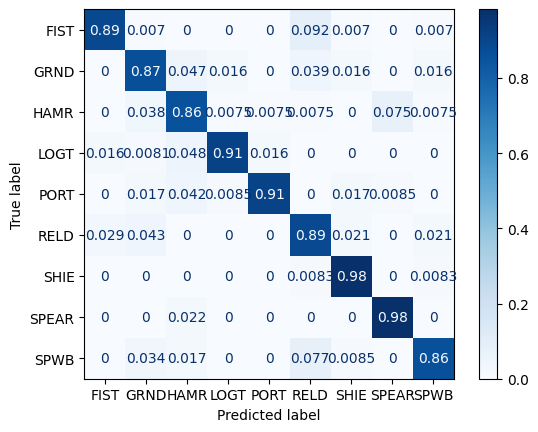

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.load_weights("best_model_fold_4.h5")
test_y_predict = np.argmax(model.predict(test_x), axis=-1)
differences = np.sum(test_y_predict != test_y)
# print((test_y_predict.shape[0] - differences) / test_y_predict.shape[0])
# print(test_y_predict)

labels = ["FIST", "GRND", "HAMR", "LOGT", "PORT", "RELD", "SHIE", "SPEAR", "SPWB"]
cm = confusion_matrix(test_y, test_y_predict)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Export Test Data and Classification Results to TXT for reference

In [ ]:
# Store test data in a file
string = ""
for test_case in test_x.to_numpy():
  for feature in test_case:
    string = string + str(feature) + "\n"
with open(f"test_x.txt", "w") as f:
  f.write(string)
  f.close()

In [ ]:
# Store classification in a file
string = ""
for result in test_y_predict:
  string = string + str(result) + "\n"
with open(f"test_y_predict.txt", "w") as f:
  f.write(string)
  f.close()

## Model Inspection

In [ ]:
model.load_weights("best_model_fold_4.h5")
# Get weights & biases (in numpy arrays)
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases  = model.layers[0].get_weights()[1]
second_layer_weights = model.layers[1].get_weights()[0]
second_layer_biases  = model.layers[1].get_weights()[1]
third_layer_weights = model.layers[2].get_weights()[0]
third_layer_biases  = model.layers[2].get_weights()[1]

In [ ]:
# Visualise
model.summary()
print("First layer weights shape:")
print(first_layer_weights.shape)
print("First layer biases:")
print(first_layer_biases.shape)
print("Second layer weights shape:")
print(second_layer_weights.shape)
print("Second layer biases:")
print(second_layer_biases.shape)
print("Third layer weights shape:")
print(third_layer_weights.shape)
print("third layer biases:")
print(third_layer_biases.shape)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 48)                3216      
                                                                 
 dense_97 (Dense)            (None, 24)                1176      
                                                                 
 dense_98 (Dense)            (None, 9)                 225       
                                                                 
Total params: 4617 (18.04 KB)
Trainable params: 4617 (18.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
First layer weights shape:
(66, 48)
First layer biases:
(48,)
Second layer weights shape:
(48, 24)
Second layer biases:
(24,)
Third layer weights shape:
(24, 9)
third layer biases:
(9,)


##Print MLP weights and biases

In [ ]:
# Store weights in a file
layer1weight_string = ""
for weight in first_layer_weights:
  for number in weight:
    layer1weight_string = layer1weight_string + str(number) + ", "
  layer1weight_string = layer1weight_string + "\n"


layer2weight_string = ""
for weight in second_layer_weights:
  for number in weight:
    layer2weight_string = layer2weight_string + str(number) + ","
  layer2weight_string = layer2weight_string + "\n"


layer3weight_string = ""
for weight in third_layer_weights:
  for number in weight:
    layer3weight_string = layer3weight_string + str(number) + ","
  layer3weight_string = layer3weight_string + "\n"


# Store biases in a file
layer1bias_string = ""
for bias in first_layer_biases:
    layer1bias_string = layer1bias_string + str(bias) + ","


layer2bias_string = ""
for bias in second_layer_biases:
    layer2bias_string = layer2bias_string + str(bias) + ","


layer3bias_string = ""
for bias in third_layer_biases:
    layer3bias_string = layer3bias_string + str(bias) + ","
print(layer3bias_string)

-0.021696068,-0.039597243,-0.06958756,-0.018217199,-0.06144576,0.11166909,0.08814053,-0.028973715,0.1361312,


## Download to local

In [ ]:
os.listdir()

['.config',
 'test_x.txt',
 'hammer_raw.csv',
 'best_model_fold_4.h5',
 'web_damien.csv',
 'portal_raw.csv',
 'logout_raw.csv',
 'shield_raw.csv',
 'best_model_fold_5.h5',
 'web_raw.csv',
 'best_model_fold_2.h5',
 'grenade_raw.csv',
 'best_model_fold_3.h5',
 'punch_raw.csv',
 'reload_raw.csv',
 'test_y_predict.txt',
 'spear_raw.csv',
 'best_model_fold_1.h5',
 'sample_data']

In [ ]:
files.download("test_x.txt")
files.download("test_y_predict.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("best_model_fold_1.h5")
files.download("best_model_fold_2.h5")
files.download("best_model_fold_3.h5")
files.download("best_model_fold_4.h5")
files.download("best_model_fold_5.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>